<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [2]:
# !wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv")
df.to_csv("./loan_train.csv",index=False)

### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

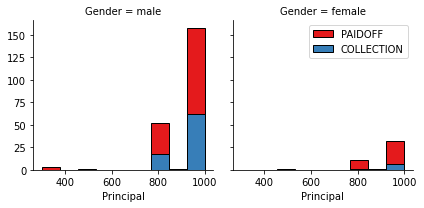

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

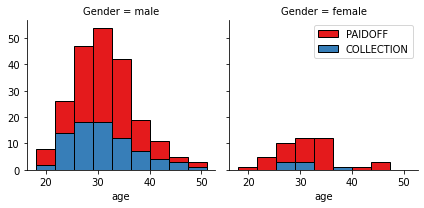

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


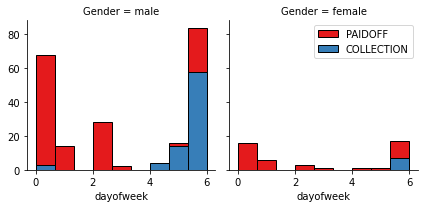

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
# y = df['loan_status'].values
y = df['loan_status'].replace(to_replace=['COLLECTION', 'PAIDOFF'], value=[0,1]).values
y[0:5]

array([1, 1, 1, 1, 1], dtype=int64)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# Preparing Training/Test Samples for Models

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state =22)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [22]:
limit = 35
mean_test = np.zeros((limit-1))
mean_train = np.zeros((limit-1))
res_train = []
res_test = []

for bestk in range(1,limit): 
    neigh = KNeighborsClassifier(n_neighbors = bestk).fit(X_train,y_train)
    
    #Train Results
    yhat = neigh.predict(X_train)
    mean_train[bestk-1] = metrics.accuracy_score(y_train, yhat)
    res_train.append("K = " + str(bestk) + "; With acc = " + str(mean_train[bestk-1]))
    
    #Test Results
    yhat = neigh.predict(X_test)
    mean_test[bestk-1] = metrics.accuracy_score(y_test, yhat)
    res_test.append("K = " + str(bestk) + "; With acc = " + str(mean_test[bestk-1]))
    
mean_test

array([0.65384615, 0.66346154, 0.66346154, 0.61538462, 0.64423077,
       0.63461538, 0.64423077, 0.64423077, 0.64423077, 0.64423077,
       0.66346154, 0.65384615, 0.65384615, 0.65384615, 0.67307692,
       0.67307692, 0.68269231, 0.67307692, 0.67307692, 0.67307692,
       0.66346154, 0.68269231, 0.66346154, 0.66346154, 0.66346154,
       0.66346154, 0.66346154, 0.67307692, 0.67307692, 0.69230769,
       0.67307692, 0.69230769, 0.67307692, 0.68269231])

In [23]:
#The Approximate value of K would be something around the square root of the sample size:
np.sqrt(242)

15.556349186104045

[0.65384615 0.66346154 0.66346154 0.61538462 0.64423077 0.63461538
 0.64423077 0.64423077 0.64423077 0.64423077 0.66346154 0.65384615
 0.65384615 0.65384615 0.67307692 0.67307692 0.68269231 0.67307692
 0.67307692 0.67307692 0.66346154 0.68269231 0.66346154 0.66346154
 0.66346154 0.66346154 0.66346154 0.67307692 0.67307692 0.69230769
 0.67307692 0.69230769 0.67307692 0.68269231]


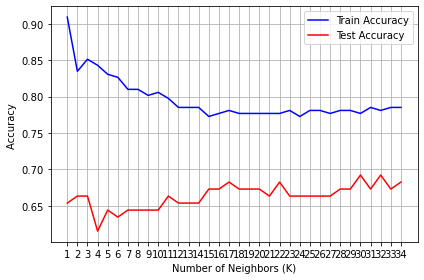

In [24]:
#When we look for values around of K=15 in order to look for the most accurate K, it shows that K=17 has a value of 0.6826923076923077 in accuracy
print(mean_test)

line1, = plt.plot(range(1,limit), mean_train, 'b', label="Train Acc")
line2, = plt.plot(range(1,limit), mean_test, 'r', label="Test Acc")

plt.legend(('Train Accuracy','Test Accuracy'))
plt.ylabel('Accuracy ')
plt.xticks(range(1,limit))
plt.grid()
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [25]:
neigh = KNeighborsClassifier(n_neighbors = 17).fit(X_train,y_train)
yhat = neigh.predict(X_test)
mean_acc_17 = metrics.accuracy_score(y_test, yhat)
std_acc_17 = np.std(yhat == y_test)/np.sqrt(yhat.shape[0])
print("K = " + str(17) + "; With acc = " + str(mean_acc_17))

K = 17; With acc = 0.6826923076923077


# Decision Tree


In [26]:
from sklearn.tree import DecisionTreeClassifier
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [27]:
max_l = 30
train_acc = []
test_acc = []

train_results = []
test_results = []

for d in range(1,max_l):
    loan_tree = DecisionTreeClassifier(criterion="entropy", max_depth = d)
    loan_tree.fit(X_train,y_train)
    
    #Train Results
    pred_tree = loan_tree.predict(X_train)
    train_results.append("max_depth = " + str(d) + "; With acc = " + str(metrics.accuracy_score(y_train, pred_tree)))
    train_acc.append(metrics.accuracy_score(y_train, pred_tree))
    
    #Test Results
    pred_tree = loan_tree.predict(X_test)
    test_results.append("max_depth = " + str(d) + "; With acc = " + str(metrics.accuracy_score(y_test, pred_tree)))
    test_acc.append(metrics.accuracy_score(y_test, pred_tree))
test_results[:18]

['max_depth = 1; With acc = 0.6730769230769231',
 'max_depth = 2; With acc = 0.6730769230769231',
 'max_depth = 3; With acc = 0.6538461538461539',
 'max_depth = 4; With acc = 0.625',
 'max_depth = 5; With acc = 0.625',
 'max_depth = 6; With acc = 0.6538461538461539',
 'max_depth = 7; With acc = 0.6538461538461539',
 'max_depth = 8; With acc = 0.6538461538461539',
 'max_depth = 9; With acc = 0.6730769230769231',
 'max_depth = 10; With acc = 0.6730769230769231',
 'max_depth = 11; With acc = 0.6634615384615384',
 'max_depth = 12; With acc = 0.6730769230769231',
 'max_depth = 13; With acc = 0.6730769230769231',
 'max_depth = 14; With acc = 0.6634615384615384',
 'max_depth = 15; With acc = 0.6634615384615384',
 'max_depth = 16; With acc = 0.6634615384615384',
 'max_depth = 17; With acc = 0.6538461538461539',
 'max_depth = 18; With acc = 0.6634615384615384']

[0.65384615 0.66346154 0.66346154 0.61538462 0.64423077 0.63461538
 0.64423077 0.64423077 0.64423077 0.64423077 0.66346154 0.65384615
 0.65384615 0.65384615 0.67307692 0.67307692 0.68269231 0.67307692
 0.67307692 0.67307692 0.66346154 0.68269231 0.66346154 0.66346154
 0.66346154 0.66346154 0.66346154 0.67307692 0.67307692 0.69230769
 0.67307692 0.69230769 0.67307692 0.68269231]


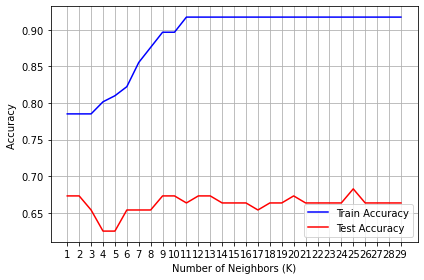

In [28]:
print(mean_test)

line1, = plt.plot(range(1,max_l), train_acc, 'b', label="Train Acc")
line2, = plt.plot(range(1,max_l), test_acc, 'r', label="Test Acc")

plt.legend(('Train Accuracy','Test Accuracy'))
plt.ylabel('Accuracy ')
plt.xticks(range(1,max_l))
plt.grid()
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [29]:
loan_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 10)
loan_tree.fit(X_train,y_train)

Yhat = loan_tree.predict(X_test)
print("max_depth = " + str(10) + "; With acc = " + str(metrics.accuracy_score(y_test, Yhat)))

max_depth = 10; With acc = 0.6730769230769231


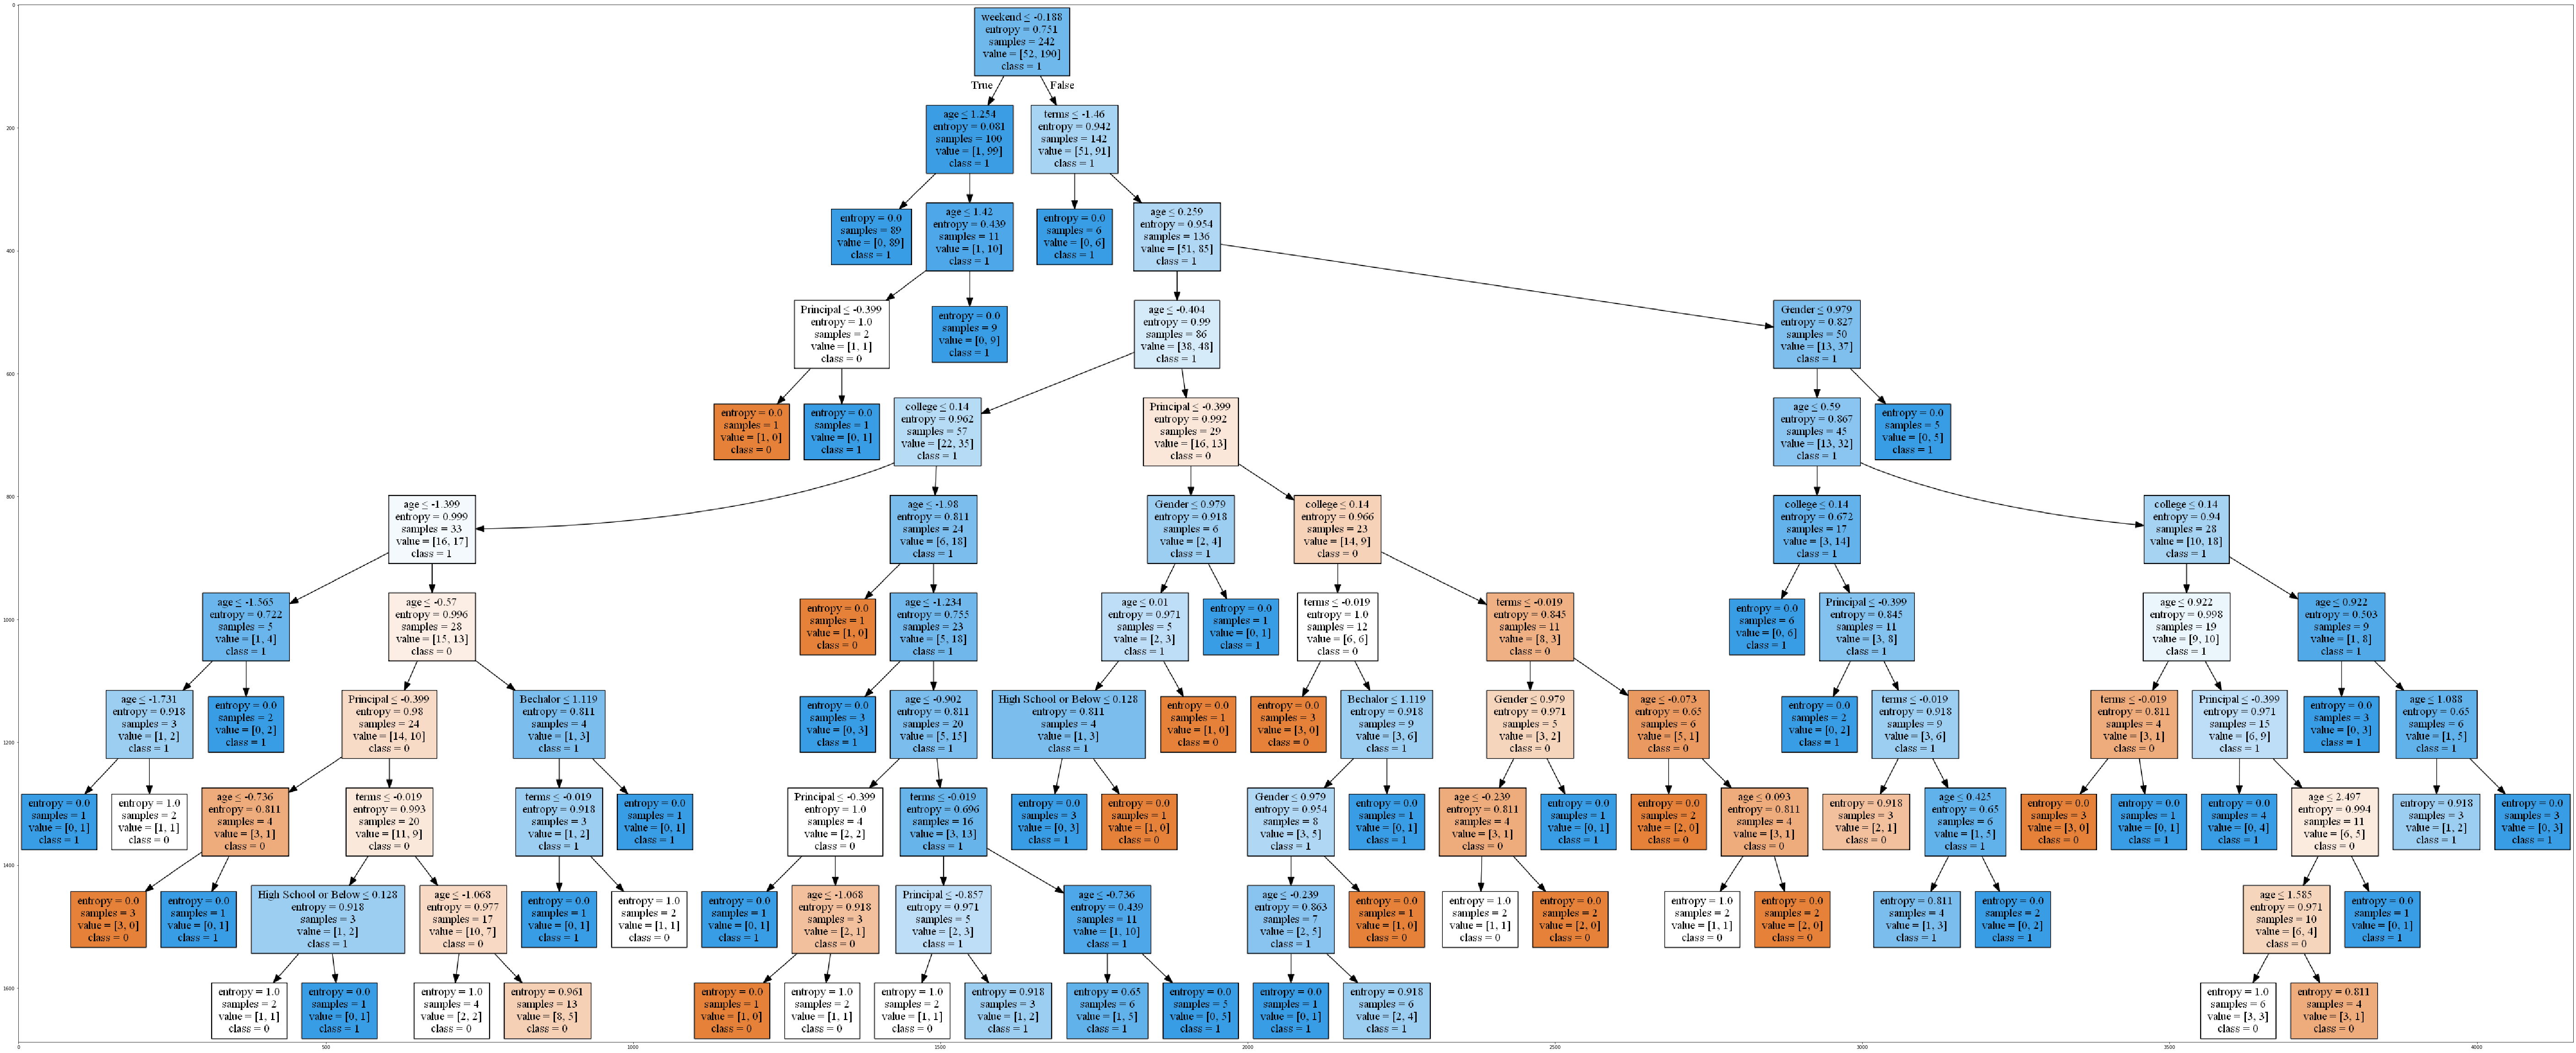

In [30]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

dot_data = StringIO()
filename = "loan_tree.png"
featureNames = Feature.columns
targetNames = df['loan_status'].apply(str).unique().tolist()
out=tree.export_graphviz(loan_tree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train.astype(str)), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [31]:
from sklearn import svm
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

In [32]:
train_res = []
test_res = []
for k in kernel:
    clf = svm.SVC(kernel=k)
    clf.fit(X_train, y_train)
    
    #Train Results
    Yhat_train = clf.predict(X_train)
    train_res.append(metrics.accuracy_score(y_train, Yhat_train))
    
    #Test Results
    Yhat_test = clf.predict(X_test)
    test_res.append(metrics.accuracy_score(y_test, Yhat_test))
test_res

[0.6730769230769231,
 0.6730769230769231,
 0.6730769230769231,
 0.6634615384615384]

In [33]:
dftrain = pd.DataFrame(train_res,kernel,columns={"Train"})
dftest = pd.DataFrame(test_res,kernel,columns={"Test"})
dfres = pd.concat([dftrain,dftest],axis=1)
dfres.head()

,Train,Test
linear,0.785124,0.673077
poly,0.805785,0.673077
rbf,0.789256,0.673077
sigmoid,0.768595,0.663462


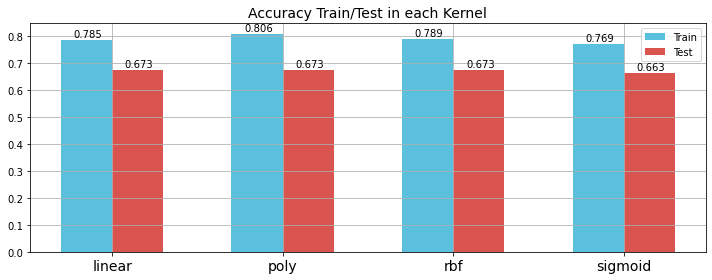

In [34]:
labels = list(map(str,dfres.index))
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(10, 4))
bar_width = 0.3

b1 = ax.bar(x,dfres['Train'],width=bar_width, label='Train',color="#5bc0de")
b2 = ax.bar(x + bar_width,dfres['Test'],width=bar_width, label='Test',color="#d9534f")

for i in ax.patches:
    ax.text(i.get_x() + bar_width/4, i.get_height()+0.01, str(round((i.get_height()), 3)), fontsize=10, color='black')

ax.legend(fontsize=10)
ax.set_title("Accuracy Train/Test in each Kernel",fontsize=14)
plt.xticks(x + bar_width / 2,labels,fontsize=14)
plt.grid()
fig.tight_layout()

In [35]:
clf = svm.SVC(kernel='poly')
clf.fit(X_train, y_train)
Yhat = clf.predict(X_test)
print("kernel = " + "poly" + "; With acc = " + str(metrics.accuracy_score(y_test, Yhat)))

kernel = poly; With acc = 0.6730769230769231


# Logistic Regression


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [37]:
params = [{'C':np.linspace(0.01,1,10),'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]
logr = LogisticRegression()
grid = GridSearchCV(logr,params,cv=4,scoring='accuracy',return_train_score=True)

grid.fit(X_train,y_train)
grid.best_estimator_

LogisticRegression(C=0.01, solver='newton-cg')

In [38]:
grid_res = grid.cv_results_
txt = []
for param,mean_val,mean_test,rank in zip(grid_res['params'],grid_res['mean_test_score'],grid_res['mean_train_score'],grid_res['rank_test_score']):
    txt.append(str(param) + "Accuracy on test:" + str(mean_val) + ", Accuracy on train:" + str(mean_test) + ", Accuracy Test Rank:" + str(rank))
txt[:5]

["{'C': 0.01, 'solver': 'newton-cg'}Accuracy on test:0.7851092896174863, Accuracy on train:0.7851223362273085, Accuracy Test Rank:1",
 "{'C': 0.01, 'solver': 'lbfgs'}Accuracy on test:0.7851092896174863, Accuracy on train:0.7851223362273085, Accuracy Test Rank:1",
 "{'C': 0.01, 'solver': 'liblinear'}Accuracy on test:0.7809426229508196, Accuracy on train:0.7837487098536822, Accuracy Test Rank:14",
 "{'C': 0.01, 'solver': 'sag'}Accuracy on test:0.7851092896174863, Accuracy on train:0.7851223362273085, Accuracy Test Rank:1",
 "{'C': 0.01, 'solver': 'saga'}Accuracy on test:0.7851092896174863, Accuracy on train:0.7851223362273085, Accuracy Test Rank:1"]

In [39]:
logr = LogisticRegression(C=0.01,solver='newton-cg')
logr.fit(X_train,y_train)
Yhat = logr.predict(X_test)
print("C = 3; With acc = " + str(metrics.accuracy_score(y_test, Yhat)))

C = 3; With acc = 0.6730769230769231


# Model Evaluation using Test set


In [40]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [41]:
# !wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
# final = pd.read_csv("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv")
# final.to_csv("./loan_test.csv",index=False)

### Load Test set for evaluation


In [42]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [43]:
#Convert to date time object
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)
test_feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [44]:
#X Loan Test
X_lt = test_feature
X_lt[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [45]:
#y Loan Test
# y_lt = test_df['loan_status'].values
y_lt = test_df['loan_status'].replace(to_replace=['COLLECTION', 'PAIDOFF'], value=[0,1]).values
y_lt[0:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [46]:
#Standarize Values
X_lt = preprocessing.StandardScaler().fit(X_lt).transform(X_lt)
X_lt[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [47]:
#For KNN
yhat_lt = neigh.predict(X_lt)
# ~Jaccard
knn_jac = jaccard_score(y_lt,yhat_lt)
# ~F1-score
knn_f1 = f1_score(y_lt,yhat_lt)

In [48]:
#For Decision Tree
yhat_lt = loan_tree.predict(X_lt)
# ~Jaccard
dt_jac = jaccard_score(y_lt,yhat_lt)
# ~F1-score
dt_f1 = f1_score(y_lt,yhat_lt)

In [49]:
#For SVM
yhat_lt = clf.predict(X_lt)
# ~Jaccard
svm_jac = jaccard_score(y_lt,yhat_lt)
# ~F1-score
svm_f1 = f1_score(y_lt,yhat_lt)

In [50]:
#For LogisticRegression
yhat_lt = logr.predict(X_lt)
yhat_lt_prob = logr.predict_proba(X_lt)
# ~Jaccard
lr_jac = jaccard_score(y_lt,yhat_lt)
# ~F1-score
lr_f1 = f1_score(y_lt,yhat_lt)
# ~LogLoss
lr_ll = log_loss(y_lt,yhat_lt_prob)

In [51]:
di = {"Jaccard":{"KNN":knn_jac,"Decision Tree":dt_jac,"SVM":svm_jac,"LogisticRegression":lr_jac},
     "F1-score":{"KNN":knn_f1,"Decision Tree":dt_f1,"SVM":svm_f1,"LogisticRegression":lr_f1},
     "LogLoss":{"KNN":"NA","Decision Tree":"NA","SVM":"NA","LogisticRegression":lr_ll}}
df_report = pd.DataFrame(di)
df_report

,Jaccard,F1-score,LogLoss
KNN,0.730769,0.844444,NA
Decision Tree,0.714286,0.833333,NA
SVM,0.685185,0.813187,NA
LogisticRegression,0.740741,0.851064,0.52885


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
